In [1]:
import os
import pickle
import numpy as np
from scipy.stats import describe
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns

sns.set(context="talk", style="ticks", color_codes=True)

from lvmdrp.core import image
from lvmdrp.functions import imageMethod
from lvmdrp.utils import database
from lvmdrp.utils import bitmask

from lvmdrp.main import load_master_config

In [2]:
config = load_master_config()

db = database.create_or_connect_db(config)

raw_flats = database.LVMFrames.select().where(
    (database.LVMFrames.imagetyp == "flat") &
    (database.LVMFrames.status == bitmask.ReductionStatus["RAW"]) &
    (database.LVMFrames.flags == bitmask.QualityFlag["OK"])
).order_by(database.LVMFrames.exptime.asc())

In [98]:
# for each flat frame
    # 	read raw frame
    #   remove overscan regions
    # 	split into amplifiers
    # 	for each amplifier
    #	 	calculate statistics (mean, variance, median, kurt, skew)
    # 		decide which frames/amplifiers go into gain calculation based in skew and kurt
    # plot sigma_counts vs sqrt(mean_counts)
    # fit slope

N_FLATS = raw_flats.count()

cache_path = "_data-lvm/gain-amps.pk"
if os.path.isfile(cache_path):
    fmin, fmax, mean, sdev, kurt, skew = pickle.load(open(cache_path, "rb"))
else:
    mean, sdev = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
    skew, kurt = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
    fmin, fmax = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
    exptimes = np.zeros(N_FLATS)
    for j, raw_flat in tqdm(enumerate(raw_flats), total=N_FLATS, desc="fetching raw flats", unit="frame", ascii=True):

        flat = image.loadImage(raw_flat.path)
        cd, ab = flat.split(2, axis="Y")
        (a, b), (c, d) = ab.split(2, axis="X"), cd.split(2, axis="X")
        # reflect b and d amplifiers to have the overscan regions in the last columns
        b.orientImage("X")
        d.orientImage("X")
        amps = [a, b, c, d]
        ny, nx = a._data.shape
        for i, (amp_name, amp) in enumerate(zip(mean.keys(), amps)):
            amps[i].cutOverscan(("1","2040"), ("1","2040"), subtract=True)
            # return original X axis orientation
            if i in [1,3]: amps[i].orientImage("X")
            # mask out pixels affected by vigneting and other border pixels (stay near the center of the CCD)
            if i in [0,1]:
                data_cut = amps[i]._data[ny//10:ny-ny//(100//40), nx//10:nx-nx//10]
            elif i in [2,3]:
                data_cut = amps[i]._data[ny-ny//(100//40):ny-ny//10, nx//10:nx-nx//10]
            stats = describe(data_cut, axis=None)
            mean[amp_name][j] = stats.mean
            sdev[amp_name][j] = np.sqrt(stats.variance)
            kurt[amp_name][j] = stats.kurtosis
            skew[amp_name][j] = stats.skewness
            fmin[amp_name][j], fmax[amp_name][j] = stats.minmax
    
        # if j == 0:
        #     break
    pickle.dump((fmin, fmax, mean, sdev, kurt, skew), open(cache_path, "wb"))


fetching raw flats: 100%|##########| 1179/1179 [18:07<00:00,  1.08frame/s]


number of frames: 6
gain = 0.009324655871063962


Text(0.5, 0, '${\\hat{F}_\\mathrm{ADU}}$')

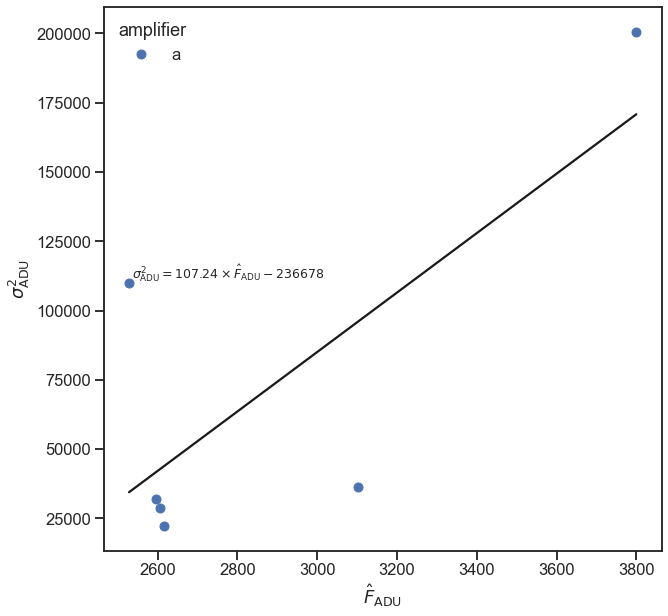

In [157]:
from scipy.optimize import least_squares


def model(par, x):
    m, b = par
    return m*x + b

def residuals(par, x, y):
    y_mod = model(par, x)
    return y_mod - y

exptimes = np.asarray([raw_flat.exptime for raw_flat in raw_flats])
mjd = np.asarray([raw_flat.mjd for raw_flat in raw_flats])
# exptimes /= exptimes.max()

fig, ax = plt.subplots(figsize=(10,10))

for amp in "a":
    x, y = mean[amp], sdev[amp]**2
    mask = np.ones_like(exptimes, dtype=bool)
    mask &= (y>=50**2)&(y<=500**2)
    mask &= (x>=2500)&(x<=40000)
    print(f"number of frames: {mask.sum()}")
    x, y = x[mask], y[mask]
    res = least_squares(fun=residuals, x0=(1,0), args=(x, y))

    xs = np.linspace(x.min(), x.max(), 100)
    ys = model(res.x, xs)
    ax.plot(x, y, "o", label=amp)
    ax.plot(xs, ys, "-k")
    ax.text(0.05, 0.5, f"$\sigma_\mathrm{{ADU}}^2 = {res.x[0]:.2f} \\times \hat{{F}}_\mathrm{{ADU}} {'+' if res.x[1]>=0 else '-'} {np.abs(res.x[1]):.0f}$", size="x-small", transform=ax.transAxes)
    print(f"gain = {1/res.x[0]}")


ax.legend(title="amplifier", ncol=2, frameon=False, loc=2)
ax.set_ylabel(r"$\sigma_\mathrm{ADU}^2$")
ax.set_xlabel(r"${\hat{F}_\mathrm{ADU}}$")
